In [2]:
import argparse
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import jax
from jax.experimental.ode import build_odeint
import jax.numpy as np
from jax.random import PRNGKey
from jax import lax

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

## Deterministic model

In [3]:
def dx_dt(x, t, beta, gamma):
    """
    SIR equations. Real positive parameters `beta`, `gamma`,
    describe the infection rate and recovery rate.
    Also tracks new infections.
    """
    S = x[0]
    I = x[1]
    R = x[2]
    n = S + I + R
    I_tot = x[3]
    dS_dt = - beta * S * I / n
    dI_dt = beta * S * I / n - gamma * I
    dR_dt = gamma * I
    dItot_dt = beta * S * I / n
    return np.stack([dS_dt, dI_dt, dR_dt, dItot_dt])

SIR_int = build_odeint(dx_dt, rtol=1e-5, atol=1e-3, mxstep=500)



## Current model: SIR model for new cases with random parameters/observations, deterministic dynamics

In [115]:
def SIR_hybrid(T = 50,
               N = 1e5,
               T_future = 0,
               duration_mean = 10,
               R0_mean = 2.2,
               gamma_shape = 5,
               beta_shape = 5,
               det_rate_mean = 0.3,
               det_rate_conc = 100,
               scale_down_mean = .0001,
               scale_down_conc = 10,
               det_conc = 100,
               use_rw = True,
               rw_scale = 1e-2,
               confirmed = None,
               ili=None):

        
    # Sample initial fraction of infected individuals
    I_init = numpyro.sample("I_init", dist.Uniform(0, 0.02))

    # Sample parameters
    gamma = numpyro.sample("gamma", 
                           dist.Gamma(gamma_shape, gamma_shape * duration_mean))
    
    beta = numpyro.sample("beta", 
                          dist.Gamma(beta_shape, beta_shape * duration_mean/R0_mean))

    det_rate = numpyro.sample("det_rate", 
                              dist.Beta(det_rate_mean * det_rate_conc,
                                        (1-det_rate_mean) * det_rate_conc))

    
    # Run simultation using ODE solve
    x_init = N * np.array([1-I_init, I_init, 0.0, I_init])
    t = np.arange(T, dtype='float32')
    x = SIR_int(x_init, t, beta, gamma)
    numpyro.deterministic("x", x)
    
    # Compute number of new infections in each time step
    latent = x[:,3]   # total number infected
    
    # Generate noisy observations as latent * Beta(a, b)
    a = det_rate * det_conc * np.ones(T)
    b = (1-det_rate) * det_conc * np.ones(T)
    
    if use_rw:
        rw = numpyro.sample("rw", dist.GaussianRandomWalk(scale=rw_scale, num_steps=T))
        loc = rw
    else:
        loc = 0.0
    
    y_dist_sir = dist.TransformedDistribution(dist.Beta(a, b), 
                                          dist.transforms.AffineTransform(loc=0, scale=latent))


    y_confirmed = numpyro.sample("y_confirmed", y_dist_sir, obs = confirmed)
    
    scale_down = numpyro.sample("scale_down", 
                              dist.Beta(scale_down_mean * scale_down_conc,
                                        (1-scale_down_mean) * scale_down_conc))
    
    y_dist_sir_rw = dist.TransformedDistribution(y_dist_sir, 
                                          dist.transforms.AffineTransform(loc=loc, scale=scale_down))
    
    
    y = numpyro.sample("y", y_dist_sir_rw, obs = ili)

    if T_future > 0:
        
        # Need to simulate for T_future + 1 time steps
        t = np.arange(T_future + 1, dtype='float32')
        x_future = SIR_int(x[-1,:], t, beta, gamma)
        x_future = x_future[1:,:] # drop first time step, which is the same as the last time step from before
        numpyro.deterministic("x_future", x_future)
        
        latent = x_future[:,3]   # total number infected

        a = det_rate * det_conc * np.ones(T_future)
        b = (1-det_rate) * det_conc * np.ones(T_future)

        if use_rw:
            # note: need to transform the random walk to add final value from previous walk
            loc = numpyro.sample("rw_future",
                                 dist.TransformedDistribution(
                                     dist.GaussianRandomWalk(scale=rw_scale, num_steps=T_future),
                                     dist.transforms.AffineTransform(loc=rw[-1], scale=1)))
        else:
            loc = 0.0
        
        y_dist = dist.TransformedDistribution(dist.Beta(a, b), 
                                              dist.transforms.AffineTransform(loc=loc, scale=latent))

        y_future = numpyro.sample("y_future", y_dist, obs = confirmed)
        
        x = np.append(x, x_future)
        y = np.append(y, y_future)
    
    return x, y, det_rate

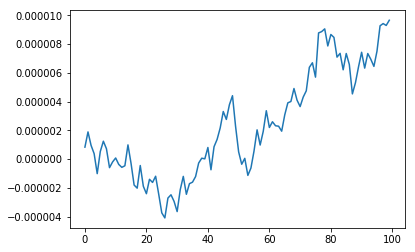

In [116]:
#with numpyro.handlers.seed(rng_seed=1):
 #   x, y, det_rate = SIR_hybrid(T=50, T_future=50, N=1e6)
  #  plt.plot(y)
    
with numpyro.handlers.seed(rng_seed=1):
    x, y, det_rate = SIR_hybrid(T=100, N=1e6,rw_scale=1e-6)
    plt.plot(y)

plt.show()

In [117]:
def plot_samples(samples, plot_fields=['I', 'y'], T=None, t=None, ax=None):
    
    X = samples['x']
    
    if 'x_future' in samples:
        X = np.append(X, samples['x_future'], axis=1)

    T_data = X.shape[1]
    if T is None or T > T_data:
        T = T_data
        
    labels = {
        'S': 'susceptible',
        'I': 'infected',
        'R': 'removed',
        'C': 'confirmed'
    }
    
    fields = {'S': X[:,:T,0],
              'I': X[:,:T,1],
              'R': X[:,:T,2],
              'C': X[:,:T,3]}    
    
    if 'y' in samples:
        y = samples['y']
        
        if 'y_future' in samples:
            y = np.append(y, samples['y_future'], axis=1)

        fields['y'] = y[:, :T]

    fields = {k: fields[k] for k in plot_fields}

    means = {k: v.mean(axis=0) for k, v in fields.items()}
    
    pred_intervals = {k: np.percentile(v, (10, 90), axis=0) for k, v in fields.items()}
    
    # Use pandas to plot means (for better date handling)
    if t is None:
        t = np.arange(T)        

    df = pd.DataFrame(index=t, data=means)
    df.plot(ax=ax)
    
    # Add prediction intervals
    for k, pred_interval in pred_intervals.items():
        ax = ax if ax is not None else plt.gca()
        ax.fill_between(t, pred_interval[0,:], pred_interval[1,:], alpha=0.1)

In [118]:
import jhu
import csv 

US = jhu.load_us()

pop = {
    'tot': 3.27e8,
    'MA': 6.902e6,
    'WA': 7.536e6,
    'NY': 8.632e6
}

place = 'NY'

start = pd.Timestamp('2020-03-02')

confirmed = US[place].confirmed[start:]
confirmed_data = confirmed.to_numpy()[-10:]
#confirmed_data = np.append(confirmed_data,np.repeat(np.nan,1))
print (confirmed_data)
T = len(confirmed_data)
N = pop[place]
ili_dat = pd.read_csv('/Users/gcgibson/covid/ili.csv')
    

kernel = NUTS(SIR_hybrid)
mcmc = MCMC(kernel, num_warmup=100, num_samples=500, num_chains=1)


init = {
    'I_init': 0.01,
    'gamma': 1/10.0,
    'beta': 2.5/10.0,
    'det_rate' : 0.3,
    'rw' : np.zeros(T)
}


ili_dat_np = np.array(ili_dat['x'])[-10:]
print (ili_dat_np)

[  421   525   732   967  1706  2495  5365  8310 11710 15793]
[0.067 0.078 0.091 0.095 0.085 0.102 0.117 0.116 0.135 0.14 ]


In [119]:
mcmc.run(jax.random.PRNGKey(2), N=N, T=T, confirmed=confirmed_data,ili=ili_dat_np, det_conc=100, rw_scale = 1e3, use_rw=True, init_params=init)
mcmc.print_summary()
mcmc_samples = mcmc.get_samples()

TypeError: <class 'NoneType'> is not a valid Jax type

In [56]:
# Visualize posterior predictive samples
T = 10
T_future = 100
post_pred = Predictive(SIR_hybrid, posterior_samples = mcmc_samples)
post_pred_samples = post_pred(PRNGKey(2), T=T, T_future=T_future, N=N)
np.mean(mcmc_samples['beta'] - mcmc_samples['gamma'])



DeviceArray(0.28023145, dtype=float32)

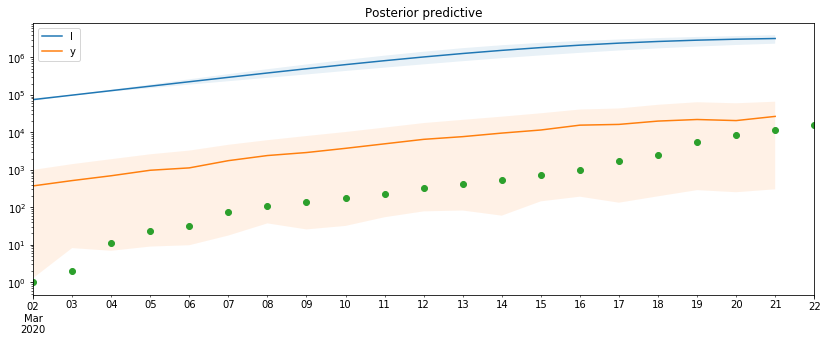

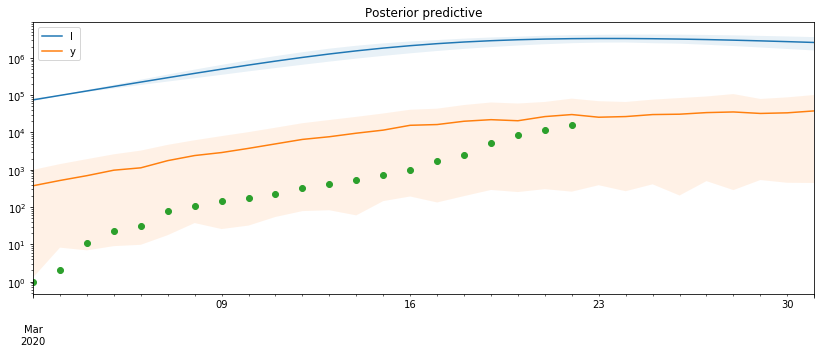

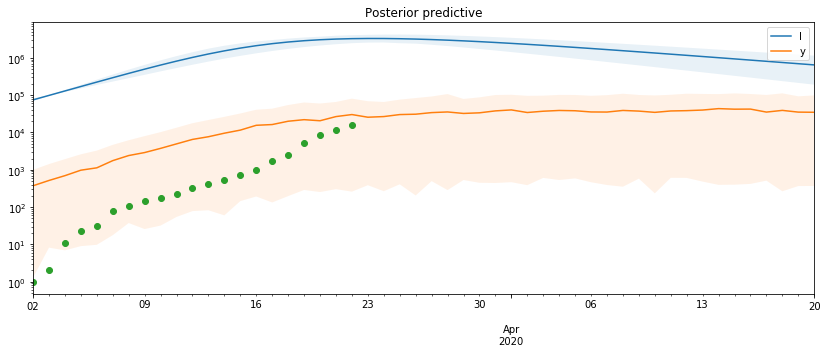

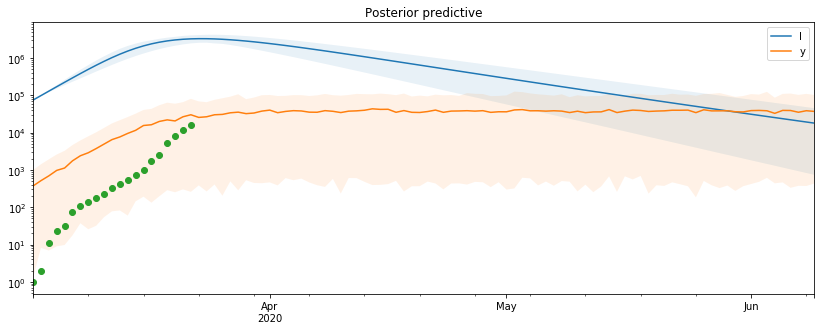

In [57]:
scale = 'log'

for T in [20, 30, 50, 100]:
    
    t = pd.date_range(start=start, periods=T, freq='D')
    
    fig, ax = plt.subplots(figsize=(14,5))
    plot_samples(post_pred_samples, T=T, t=t, ax=ax, plot_fields=['I', 'y'])
    plt.title('Posterior predictive')
    
    confirmed.plot(style='o')
    
    if scale == 'log':
        plt.yscale('log')
        
    #filename = f'figs/{place}_predictive_scale_{scale}_T_{T}.pdf'
    #plt.savefig(filename)
    plt.show()
    

In [89]:
print(post_pred_samples['x'].shape)
print(post_pred_samples['x_future'].shape)

(500, 21, 4)
(500, 100, 4)
